In [1]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st
import matplotlib.colors as mcolors

In [2]:
file = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.7_5.features', dtype=str)
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')
cin_loc = pd.read_table('../data/cin_locations.txt')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep='\t')
ascat = pd.read_table('/home/janneae/cns/data/filteredAscatRaw.txt', dtype=str)

In [22]:
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [23]:
df.head()

,CN,SegSize,Dist2Cent,SegVal,LOH,SizeDipSeg,BpC,Dist2nCNV,GCcSeg,NumRepeats
0,CN_3,SegSize_6,Dist2Cent_3,SegVal_4,LOH_0,SizeDipSeg_2,BpC_2,Dist2CNV_5,GCcSeg_3,NumRepeats_5
1,CN_3,SegSize_5,Dist2Cent_4,SegVal_5,LOH_0,SizeDipSeg_1,BpC_4,Dist2CNV_2,GCcSeg_3,NumRepeats_3
2,CN_3,SegSize_5,Dist2Cent_4,SegVal_2,LOH_0,SizeDipSeg_1,BpC_2,Dist2CNV_4,GCcSeg_2,NumRepeats_4
3,CN_2,SegSize_6,Dist2Cent_2,SegVal_1,LOH_0,SizeDipSeg_3,BpC_2,Dist2CNV_2,GCcSeg_1,NumRepeats_5
4,CN_2,SegSize_5,Dist2Cent_5,SegVal_2,LOH_0,SizeDipSeg_2,BpC_4,Dist2CNV_3,GCcSeg_1,NumRepeats_2


In [5]:
lda = LdaModel.load('../results/gensim/lda/lda_t5_f10_b5.model')

In [24]:
lda = LdaModel.load('../results/gensim/lda/lda_t5_f11_b5.model')

## Tweaking parameters of LDA analysis

In [25]:
def create_heatmap(model, df, corpus):
    topics = model.get_document_topics(bow = corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

def correlate(cin, survival, val, test):
    gender = []
    age = []
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        gender.append(test(survival[f'{i}'], survival['Gender'])[val])
        age.append(test(survival[f'{i}'], survival['Age_at_diagnosis'])[val])
        
        tel.append(test(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(test(cin[f'{i}'], cin['lst'])[val])
        hrd.append(test(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(test(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(test(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(test(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(test(cin[f'{i}'], cin['wFLOH'])[val])

    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Gender'] = gender
    corr_df['Age_at_diagnosis'] = age
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH

    corr_df = corr_df.set_index('Signature')
    # corr_df = corr_df.transpose()
    
    return corr_df

In [6]:
lda = LdaModel(
    corpus=bow_corpus,
    id2word=dirichlet_dict,
    num_topics=5,
    chunksize=len(bow_corpus),
    alpha='symmetric',
    eta='symmetric',
    random_state=42)

In [7]:
coherences = CoherenceModel(model=lda, corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = 50).get_coherence()
coherences

0.3265685780533919

In [26]:
weights_df = weights_df = create_heatmap(lda, file, bow_corpus)
weights_df = weights_df[weights_df['Chr'] != 23]

In [27]:
gene_expT = gene_exp.transpose()
gene_expT['Sample'] = gene_expT.index

exp = weights_df.reset_index(drop=True).drop(['Chr'], axis = 1).drop_duplicates(subset = ["Sample"])
exp.columns = ['Sample', 'Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5']
exp = pd.merge(left = exp, right = gene_expT, on = 'Sample')
exp.index = exp['Sample']
exp = exp.drop(['Sample'], axis = 1)
exp_final = exp.drop(['Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5'], axis = 1)

cin_70 = list(cin_loc['Gene'])

cin70_expT = exp_final[exp_final.columns.intersection(cin_70)]
cin70_expT['mean'] = cin70_expT.mean(axis=1)

cin70_corr = []
cin70_pval = []

for signature in range(1, 6):
    cin70_corr.append(st.spearmanr(exp[f'Sig{signature}'], cin70_expT['mean'])[0])
    cin70_pval.append(st.spearmanr(exp[f'Sig{signature}'], cin70_expT['mean'])[1])

/scratch/2082332/ipykernel_49493/2421708433.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cin70_expT['mean'] = cin70_expT.mean(axis=1)


In [28]:
combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df['Gender'] = survivaldata['gender']
combined_df['Gender'] = pd.factorize(combined_df['Gender'])[0]
combined_df = combined_df.dropna()

cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ").set_index('sample_id').reindex(index=weights_df['Sample']).reset_index()
combined_cin = weights_df.reset_index()
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna()

corr_df = correlate(combined_cin, combined_df, 0, st.spearmanr)
corr_df['CIN70'] = cin70_corr
pval_df = correlate(combined_cin, combined_df, 1, st.spearmanr)
pval_df['CIN70'] = cin70_pval
corr_df = corr_df.transpose()
pval_df = pval_df.transpose()

In [29]:
alpha = 0.001/176000

for i in range(1, 5):
    for j in range(1, 7):
        if pval_df[i][j] > alpha:
            corr_df[i][j] = 0
corr_df

Signature,1,2,3,4,5
Gender,-0.011023,0.016820,-0.003255,0.007197,0.028322
Age_at_diagnosis,0.000000,0.000000,0.000000,0.000000,0.000768
Telomeric.AI,-0.248210,0.411230,-0.286689,0.061651,0.061544
LST,-0.240092,0.377732,-0.258118,0.052310,0.061202
HRD,-0.246178,0.328548,-0.215979,0.015628,0.091146
HRD_score,-0.262820,0.407592,-0.279180,0.050980,0.072788
Ploidy,0.042970,0.140200,-0.166919,0.182528,-0.059092
wGII,-0.178015,0.349711,-0.263773,0.112354,0.053014
wFLOH,-0.248977,0.331874,-0.227933,0.033517,0.104409
CIN70,-0.171620,0.333217,-0.265792,0.098187,0.021552


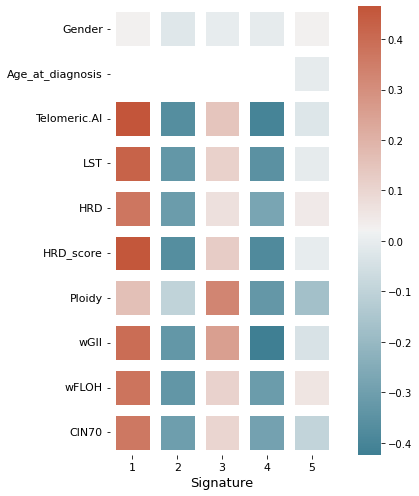

In [20]:
palette = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=13)
ax.tick_params(axis="both", labelsize=11)
f.tight_layout()
plt.savefig('../figures/correlation_matrix.pdf')

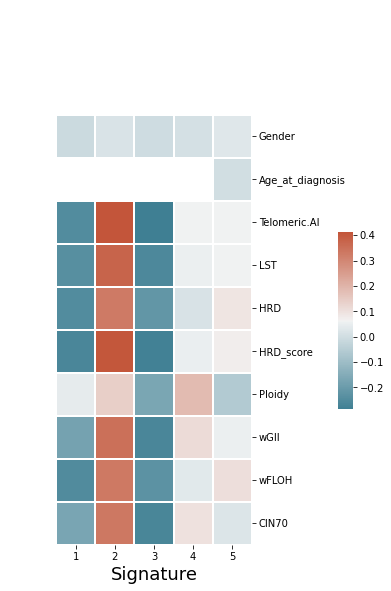

In [30]:
clustermap_df = corr_df
g = sns.clustermap(
    clustermap_df, cmap=palette, 
    cbar_pos=(0.95, .3, .04, .3),
    figsize=(5,8.2), linewidths=0.004,
    dendrogram_ratio=0.2, mask= clustermap_df==0,
    row_cluster=False, col_cluster=False
    # standard_scale=0
    )
# g.ax_heatmap.set_xlabel('Attribute', fontsize=15)
g.ax_heatmap.set_xlabel('Signature', fontsize=18)
g.savefig('../figures/cin_clustermapGC.pdf')

In [23]:
corr_df

Signature,1,2,3,4,5
Gender,-0.000504,-0.027603,-0.001835,0.005807,0.016307
Age_at_diagnosis,0.000000,0.000000,0.000000,0.000000,-0.003304
Telomeric.AI,0.099557,-0.176746,0.282908,-0.209585,0.024829
LST,0.064151,-0.166139,0.236561,-0.168642,0.043713
HRD,0.000000,-0.162693,0.207909,-0.130641,0.069523
HRD_score,0.069585,-0.183808,0.268177,-0.189564,0.046760
Ploidy,0.227111,0.100814,0.143220,-0.258688,-0.128989
wGII,0.142003,-0.093170,0.249344,-0.250994,-0.006396
wFLOH,0.010318,-0.139830,0.212765,-0.134118,0.050902
CIN70,0.100891,-0.206206,0.166232,-0.222284,0.092201
